In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.random as nr
import math
from sklearn import preprocessing

%matplotlib inline

In [3]:
AdvWorksCusts = pd.read_csv('./Data/AdvWorksCusts.csv')
AW_AveMonthSpend = pd.read_csv('./Data/AW_AveMonthSpend.csv')
AW_BikeBuyer = pd.read_csv('./Data/AW_BikeBuyer.csv')
AW_test = pd.read_csv('./Data/AW_test.csv')
print(AdvWorksCusts.shape, AW_AveMonthSpend.shape, AW_BikeBuyer.shape)
AdvWorksCusts.head()

(16519, 23) (16519, 2) (16519, 2)


,CustomerID,Title,FirstName,MiddleName,LastName,Suffix,AddressLine1,AddressLine2,City,StateProvinceName,...,BirthDate,Education,Occupation,Gender,MaritalStatus,HomeOwnerFlag,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome
0,11000,NaN,Jon,V,Yang,NaN,3761 N. 14th St,NaN,Rockhampton,Queensland,...,1966-04-08,Bachelors,Professional,M,M,1,0,0,2,137947
1,11001,NaN,Eugene,L,Huang,NaN,2243 W St.,NaN,Seaford,Victoria,...,1965-05-14,Bachelors,Professional,M,S,0,1,3,3,101141
2,11002,NaN,Ruben,NaN,Torres,NaN,5844 Linden Land,NaN,Hobart,Tasmania,...,1965-08-12,Bachelors,Professional,M,M,1,1,3,3,91945
3,11003,NaN,Christy,NaN,Zhu,NaN,1825 Village Pl.,NaN,North Ryde,New South Wales,...,1968-02-15,Bachelors,Professional,F,S,0,1,0,0,86688
4,11004,NaN,Elizabeth,NaN,Johnson,NaN,7553 Harness Circle,NaN,Wollongong,New South Wales,...,1968-08-08,Bachelors,Professional,F,S,1,4,5,5,92771


### Checking the missing values

In [4]:
# Identify the columns with missing values
pd.isna(AdvWorksCusts).any()

## Remove rows with missing values, accounting for mising values coded as '?'
# cols = ['Title', 'MiddleName', 'Suffix', 'AddressLine2']
# AdvWorksCusts.dropna(axis = 0, inplace = True)
# AdvWorksCusts.shape 

CustomerID              False
Title                    True
FirstName               False
MiddleName               True
LastName                False
Suffix                   True
AddressLine1            False
AddressLine2             True
City                    False
StateProvinceName       False
CountryRegionName       False
PostalCode              False
PhoneNumber             False
BirthDate               False
Education               False
Occupation              False
Gender                  False
MaritalStatus           False
HomeOwnerFlag           False
NumberCarsOwned         False
NumberChildrenAtHome    False
TotalChildren           False
YearlyIncome            False
dtype: bool

### Replacing the duplicates

In [5]:
# Identify the rows of duplicates
AW_AveMonthSpend.shape[0] - AW_AveMonthSpend.CustomerID.unique().shape[0]
AW_BikeBuyer.shape[0] - AW_BikeBuyer.CustomerID.unique().shape[0]
AdvWorksCusts.shape[0] - AdvWorksCusts.CustomerID.unique().shape[0]

115

In [6]:
# Remove them
AdvWorksCusts.drop_duplicates(subset = 'CustomerID', keep = 'first', inplace = True)
AW_AveMonthSpend.drop_duplicates(subset = 'CustomerID', keep = 'first', inplace = True)
AW_BikeBuyer.drop_duplicates(subset = 'CustomerID', keep = 'first', inplace = True)

In [7]:
# Save the dataframe to a csv file 
AdvWorksCusts.to_csv('./PreparedData/AdvWorksCusts_Preped.csv', index = False, header = True)
AW_AveMonthSpend.to_csv('./PreparedData/AW_AveMonthSpend_Preped.csv', index = False, header = True)
AW_BikeBuyer.to_csv('./PreparedData/AW_BikeBuyer_Preped.csv', index = False, header = True)

### Encode features and label for predicting potential BikeBuyer

In [8]:
AdvWorksCusts = AdvWorksCusts.merge(AW_BikeBuyer, on='CustomerID')
AdvWorksCusts.shape

(16404, 24)

In [9]:
def encoding_string(cat_features):
    # Encode the string to numeric values
    enc = preprocessing.LabelEncoder().fit(cat_features)
    enc_cat_features = enc.transform(cat_features)
    # One-hot encoding
    ohe = preprocessing.OneHotEncoder().fit(enc_cat_features.reshape(-1,1))
    encoded = ohe.transform(enc_cat_features.reshape(-1,1)).toarray()
    return encoded

## Prepare Data

Labels = np.array(AdvWorksCusts['BikeBuyer'])
pd.DataFrame(Labels).to_csv('./PreparedData/BikeBuyerLabels.csv', index = False, header = True)

# Deal with categorical variables (Features)
Features = np.zeros((AdvWorksCusts.shape[0], 1))  ## dummy column

categorical_columns = ['Education', 'Occupation', 'Gender', 'MaritalStatus', 'HomeOwnerFlag', 
                       'NumberCarsOwned', 'NumberChildrenAtHome', 'TotalChildren']

for col in categorical_columns:
    temp = encoding_string(AdvWorksCusts[col])
    #print(temp.shape)
    Features = np.concatenate([Features, temp], axis=1)
# Drop the first dummy column
Features = np.delete(Features, 0, axis=1)

## Deal with numeric variables (Features)
num_features = np.array(AdvWorksCusts['YearlyIncome']).reshape(-1, 1)
# Scale numeric variables
num_features = preprocessing.StandardScaler().fit(num_features).transform(num_features)
# Add numeric features at the end
Features = np.concatenate([Features, num_features], axis=1)

pd.DataFrame(Features).to_csv('./PreparedData/BikeBuyerFeatures.csv', index = False, header = True)

### Test Data Prediction for predicting potential BikeBuyer

In [10]:
## Test data preparetion
## Deal with categorical variable
Features_test = np.zeros((AW_test.shape[0], 1))  ## dummy column

categorical_columns = ['Education', 'Occupation', 'Gender', 'MaritalStatus', 'HomeOwnerFlag', 
                       'NumberCarsOwned', 'NumberChildrenAtHome', 'TotalChildren']
for col in categorical_columns:
    temp = encoding_string(AW_test[col])
    Features_test = np.concatenate([Features_test, temp], axis=1)
# Drop the first dummy column
Features_test = np.delete(Features_test, 0, axis=1)

## Deal with numeric variables (Features)
num_features_test = np.array(AW_test['YearlyIncome']).reshape(-1, 1)
# Scale numeric variables
num_features_test = preprocessing.StandardScaler().fit(num_features_test).transform(num_features_test)
# Add numeric features at the end
Features_test = np.concatenate([Features_test, num_features_test], axis=1)

pd.DataFrame(Features_test).to_csv('./PreparedData/Features_test.csv', index = False, header = True)

### Encode features and label for predicting a customer's average monthly spend

In [11]:
AdvWorksCusts = AdvWorksCusts.merge(AW_AveMonthSpend, on='CustomerID')
AdvWorksCusts['log_AveMonthSpend'] = np.log(np.array(AdvWorksCusts['AveMonthSpend']))
AdvWorksCusts.head()

,CustomerID,Title,FirstName,MiddleName,LastName,Suffix,AddressLine1,AddressLine2,City,StateProvinceName,...,Gender,MaritalStatus,HomeOwnerFlag,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome,BikeBuyer,AveMonthSpend,log_AveMonthSpend
0,11000,NaN,Jon,V,Yang,NaN,3761 N. 14th St,NaN,Rockhampton,Queensland,...,M,M,1,0,0,2,137947,0,89,4.488636
1,11001,NaN,Eugene,L,Huang,NaN,2243 W St.,NaN,Seaford,Victoria,...,M,S,0,1,3,3,101141,1,117,4.762174
2,11002,NaN,Ruben,NaN,Torres,NaN,5844 Linden Land,NaN,Hobart,Tasmania,...,M,M,1,1,3,3,91945,0,123,4.812184
3,11003,NaN,Christy,NaN,Zhu,NaN,1825 Village Pl.,NaN,North Ryde,New South Wales,...,F,S,0,1,0,0,86688,0,50,3.912023
4,11004,NaN,Elizabeth,NaN,Johnson,NaN,7553 Harness Circle,NaN,Wollongong,New South Wales,...,F,S,1,4,5,5,92771,1,95,4.553877


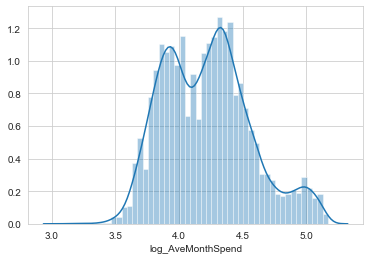

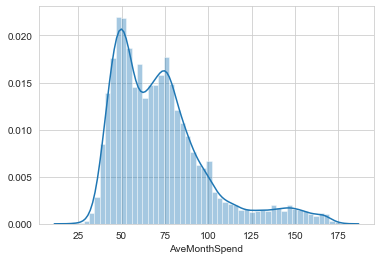

In [14]:
def plot_distribution(val):
    sns.set_style('whitegrid')
    sns.distplot(val)
    plt.show()
    
plot_distribution(AdvWorksCusts['log_AveMonthSpend'])
plot_distribution(AdvWorksCusts['AveMonthSpend'])

In [13]:
def encoding_string(cat_features):
    # Encode the string to numeric values
    enc = preprocessing.LabelEncoder().fit(cat_features)
    enc_cat_features = enc.transform(cat_features)
    # One-hot encoding
    ohe = preprocessing.OneHotEncoder().fit(enc_cat_features.reshape(-1,1))
    encoded = ohe.transform(enc_cat_features.reshape(-1,1)).toarray()
    return encoded

## Prepare Data

Labels = np.array(AdvWorksCusts['log_AveMonthSpend'])
pd.DataFrame(Labels).to_csv('./PreparedData/AveMonthSpendLabels.csv', index = False, header = True)

# Deal with categorical variables (Features)
Features = np.zeros((AdvWorksCusts.shape[0], 1))  ## dummy column

categorical_columns = ['Education', 'Occupation', 'Gender', 'MaritalStatus', 'HomeOwnerFlag', 
                       'NumberCarsOwned', 'NumberChildrenAtHome', 'TotalChildren']

for col in categorical_columns:
    temp = encoding_string(AdvWorksCusts[col])
    #print(temp.shape)
    Features = np.concatenate([Features, temp], axis=1)
# Drop the first dummy column
Features = np.delete(Features, 0, axis=1)

## Deal with numeric variables (Features)
num_features = np.array(AdvWorksCusts['YearlyIncome']).reshape(-1, 1)
# Scale numeric variables
num_features = preprocessing.StandardScaler().fit(num_features).transform(num_features)
# Add numeric features at the end
Features = np.concatenate([Features, num_features], axis=1)

pd.DataFrame(Features).to_csv('./PreparedData/AveMonthSpendFeatures.csv', index = False, header = True)